<a href="https://colab.research.google.com/github/kittikhun62/efficientnet_keras_transfer_learning/blob/master/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#เรียกใช้ CSV

In [1]:
import pandas as pd
import shutil

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df = pd.read_csv (r'/content/drive/My Drive/data - All SEM.csv')
df

,No,Name_file,Name_Paper,journal,path_Picture,detail,Class,BET,Size(mico)
0,1,pore-sb,Preparation and electrochemical behaviour of b...,Korean J. Chem. Eng,/content/drive/My Drive/All SEM/pore-sb/PCC(RS...,original,0-500,135.06,5
1,2,pore-sb,Preparation and electrochemical behaviour of b...,Korean J. Chem. Eng,/content/drive/My Drive/All SEM/pore-sb/PCC(RS...,zoom1,0-500,135.06,10
2,3,pore-sb,Preparation and electrochemical behaviour of b...,Korean J. Chem. Eng,/content/drive/My Drive/All SEM/pore-sb/PCC(RS...,zoom2,0-500,135.06,10
3,4,pore-sb,Preparation and electrochemical behaviour of b...,Korean J. Chem. Eng,/content/drive/My Drive/All SEM/pore-sb/PCC(RS...,zoom3,0-500,135.06,10
4,5,pore-sb,Preparation and electrochemical behaviour of b...,Korean J. Chem. Eng,/content/drive/My Drive/All SEM/pore-sb/PCC(RS...,zoom4,0-500,135.06,10
...,...,...,...,...,...,...,...,...,...
315,316,1-s2.0-S0926669022000292-main,Low-cost activated carbon preparation from Cor...,Industrial Crops & Products,/content/drive/My Drive/All SEM/1-s2.0-S092666...,original,0-500,11.00,10
316,317,1-s2.0-S0926669022000292-main,Low-cost activated carbon preparation from Cor...,Industrial Crops & Products,/content/drive/My Drive/All SEM/1-s2.0-S092666...,original,0-500,0.25,10
317,318,1-s2.0-S0926669022000292-main,Low-cost activated carbon preparation from Cor...,Industrial Crops & Products,/content/drive/My Drive/All SEM/1-s2.0-S092666...,original,0-500,35.00,10
318,319,1-s2.0-S0926669022000292-main,Low-cost activated carbon preparation from Cor...,Industrial Crops & Products,/content/drive/My Drive/All SEM/1-s2.0-S092666...,original,501-1000,583.00,10


## hist


In [4]:
import matplotlib.pyplot as plt

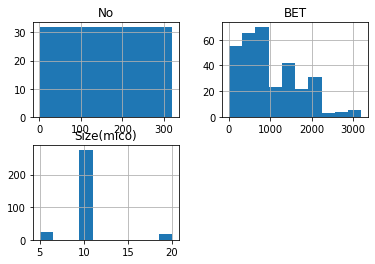

In [5]:
df.hist();

In [6]:
a = df['BET']

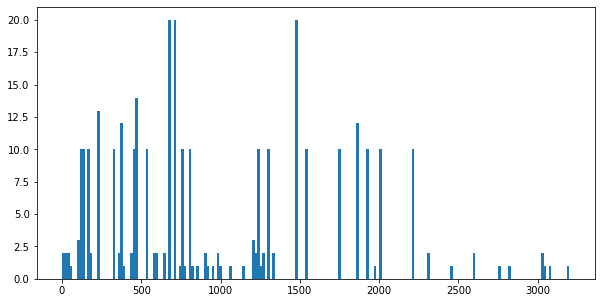

In [7]:
fig, ax = plt.subplots(figsize =(10, 5))
ax.hist(a, bins = 200)
plt.show()

In [8]:
classes = ['0-500','501-1000','1001-1500','1501-2000','2001-2500','2501-3000','3001-3500']
len(classes)

7

#Imports

In [9]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import os
import glob
import shutil
import sys
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline

#กำหนดค่าพารามิเตอร์


In [10]:
batch_size = 20
width = 150
height = 150
epochs = 20
NUM_TRAIN = 300 
NUM_TEST = 20
dropout_rate = 0.2
input_shape = (height, width, 3)

#Clone efficientnet repo


In [11]:
#ดึงข้อมูลใน Github มาใช้
import os
%cd /content
if not os.path.isdir("efficientnet_keras_transfer_learning"):
 !git clone https://github.com/Wanita-8943/efficientnet_keras_transfer_learning
%cd efficientnet_keras_transfer_learning/


/content
/content/efficientnet_keras_transfer_learning


In [12]:
# Options: EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3
# Higher the number, the more complex the model is.
from efficientnet import EfficientNetB0 as Net
from efficientnet import center_crop_and_resize, preprocess_input

In [13]:
# loading pretrained conv base model
# โหลดโมเดล มาโดยตัด output ของโมเดลออก เเต่ยังใช้ input อันเดิม
# เเละโหลด weight ของโมเดล มาด้วยที่ชื่อว่า imagenet
conv_base = Net(weights='imagenet', include_top=False, input_shape=input_shape)

In [14]:
conv_base.summary() #ดู Summary

Model: "efficientnet-b0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 75, 75, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 75, 75, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                    

#Download 

In [15]:
base_dir = '/content/drive/My Drive/Project'
os.makedirs(base_dir, exist_ok=True)

# Directories for our training,
# validation and test splits
train_dir = os.path.join(base_dir, 'train')
os.makedirs(train_dir, exist_ok=True)
validation_dir = os.path.join(base_dir, 'validation')
os.makedirs(validation_dir, exist_ok=True)
test_dir = os.path.join(base_dir, 'test')
os.makedirs(test_dir, exist_ok=True)

In [16]:
classes = ['0-500','501-1000','1001-1500','1501-2000','2001-2500','2501-3000','3001-3500']
len(classes)

7

In [17]:
train_1_dir = os.path.join(train_dir, '0-500')
os.makedirs(train_1_dir, exist_ok=True)

train_2_dir = os.path.join(train_dir, '501-1000')
os.makedirs(train_2_dir, exist_ok=True)

train_3_dir = os.path.join(train_dir, '1001-1500')
os.makedirs(train_3_dir, exist_ok=True)

train_4_dir = os.path.join(train_dir, '1501-2000')
os.makedirs(train_4_dir, exist_ok=True)

train_5_dir = os.path.join(train_dir, '2001-2500')
os.makedirs(train_5_dir, exist_ok=True)

train_6_dir = os.path.join(train_dir, '2501-3000')
os.makedirs(train_6_dir, exist_ok=True)

train_7_dir = os.path.join(train_dir, '3001-3500')
os.makedirs(train_7_dir, exist_ok=True)

validation_1_dir = os.path.join(validation_dir, '0-500')
os.makedirs(validation_1_dir, exist_ok=True)

validation_2_dir = os.path.join(validation_dir, '501-1000')
os.makedirs(validation_2_dir, exist_ok=True)

validation_3_dir = os.path.join(validation_dir, '1001-1500')
os.makedirs(validation_3_dir, exist_ok=True)

validation_4_dir = os.path.join(validation_dir, '1501-2000')
os.makedirs(validation_4_dir, exist_ok=True)

validation_5_dir = os.path.join(validation_dir, '2001-2500')
os.makedirs(validation_5_dir, exist_ok=True)

validation_6_dir = os.path.join(validation_dir, '2501-3000')
os.makedirs(validation_6_dir, exist_ok=True)

validation_7_dir = os.path.join(validation_dir, '3001-3500')
os.makedirs(validation_7_dir, exist_ok=True)

test_1_dir = os.path.join(test_dir, '0-500')
os.makedirs(test_1_dir, exist_ok=True)

test_2_dir = os.path.join(test_dir, '501-1000')
os.makedirs(test_2_dir, exist_ok=True)

test_3_dir = os.path.join(test_dir, '1001-1500')
os.makedirs(test_3_dir, exist_ok=True)

test_4_dir = os.path.join(test_dir, '1501-2000')
os.makedirs(test_4_dir, exist_ok=True)

test_5_dir = os.path.join(test_dir, '2001-2500')
os.makedirs(test_5_dir, exist_ok=True)

test_6_dir = os.path.join(test_dir, '2501-3000')
os.makedirs(test_6_dir, exist_ok=True)

test_7_dir = os.path.join(test_dir, '3001-3500')
os.makedirs(test_7_dir, exist_ok=True)



In [18]:
df

,No,Name_file,Name_Paper,journal,path_Picture,detail,Class,BET,Size(mico)
0,1,pore-sb,Preparation and electrochemical behaviour of b...,Korean J. Chem. Eng,/content/drive/My Drive/All SEM/pore-sb/PCC(RS...,original,0-500,135.06,5
1,2,pore-sb,Preparation and electrochemical behaviour of b...,Korean J. Chem. Eng,/content/drive/My Drive/All SEM/pore-sb/PCC(RS...,zoom1,0-500,135.06,10
2,3,pore-sb,Preparation and electrochemical behaviour of b...,Korean J. Chem. Eng,/content/drive/My Drive/All SEM/pore-sb/PCC(RS...,zoom2,0-500,135.06,10
3,4,pore-sb,Preparation and electrochemical behaviour of b...,Korean J. Chem. Eng,/content/drive/My Drive/All SEM/pore-sb/PCC(RS...,zoom3,0-500,135.06,10
4,5,pore-sb,Preparation and electrochemical behaviour of b...,Korean J. Chem. Eng,/content/drive/My Drive/All SEM/pore-sb/PCC(RS...,zoom4,0-500,135.06,10
...,...,...,...,...,...,...,...,...,...
315,316,1-s2.0-S0926669022000292-main,Low-cost activated carbon preparation from Cor...,Industrial Crops & Products,/content/drive/My Drive/All SEM/1-s2.0-S092666...,original,0-500,11.00,10
316,317,1-s2.0-S0926669022000292-main,Low-cost activated carbon preparation from Cor...,Industrial Crops & Products,/content/drive/My Drive/All SEM/1-s2.0-S092666...,original,0-500,0.25,10
317,318,1-s2.0-S0926669022000292-main,Low-cost activated carbon preparation from Cor...,Industrial Crops & Products,/content/drive/My Drive/All SEM/1-s2.0-S092666...,original,0-500,35.00,10
318,319,1-s2.0-S0926669022000292-main,Low-cost activated carbon preparation from Cor...,Industrial Crops & Products,/content/drive/My Drive/All SEM/1-s2.0-S092666...,original,501-1000,583.00,10


In [24]:
val = df[df['No'].between(257,289)]
train = df[df['No'].between(1,256)]
test = df[df['No'].between(290,320)] 

#Path Train
T1_train = train[train['Class']=='0-500' ]
T1_path_train = T1_train['path_Picture'].tolist() 
T2_train = train[train['Class']=='501-1000' ]
T2_path_train = T2_train['path_Picture'].tolist() 
T3_train = train[train['Class']=='1001-1500' ]
T3_path_train = T3_train['path_Picture'].tolist()
T4_train = train[train['Class']=='1501-2000' ]
T4_path_train = T4_train['path_Picture'].tolist()
T5_train = train[train['Class']=='2001-2500' ]
T5_path_train = T5_train['path_Picture'].tolist()
T6_train = train[train['Class']=='2501-3000' ]
T6_path_train = T6_train['path_Picture'].tolist()
T7_train = train[train['Class']=='3001-3500' ]
T7_path_train = T7_train['path_Picture'].tolist()

#Path Validation
T1_val = val[val['Class']=='0-500' ]
T1_path_val = T1_val['path_Picture'].tolist() 
T2_val = val[val['Class']=='501-1000' ]
T2_path_val = T2_val['path_Picture'].tolist() 
T3_val = val[val['Class']=='1001-1500' ]
T3_path_val = T3_val['path_Picture'].tolist()
T4_val = val[val['Class']=='1501-2000' ]
T4_path_val = T4_val['path_Picture'].tolist()
T5_val = val[val['Class']=='2001-2500' ]
T5_path_val = T5_val['path_Picture'].tolist()
T6_val = val[val['Class']=='2501-3000' ]
T6_path_val = T6_val['path_Picture'].tolist()
T7_val = val[val['Class']=='3001-3500' ]
T7_path_val = T7_val['path_Picture'].tolist()

#Path Test
T1_test = test[test['Class']=='0-500' ]
T1_path_test = T1_test['path_Picture'].tolist() 
T2_test = test[test['Class']=='501-1000' ]
T2_path_test = T2_test['path_Picture'].tolist() 
T3_test = test[test['Class']=='1001-1500' ]
T3_path_test = T3_test['path_Picture'].tolist()
T4_test = test[test['Class']=='1501-2000' ]
T4_path_test = T4_test['path_Picture'].tolist()
T5_test = test[test['Class']=='2001-2500' ]
T5_path_test = T5_test['path_Picture'].tolist()
T6_test = test[test['Class']=='2501-3000' ]
T6_path_test = T6_test['path_Picture'].tolist()
T7_test = test[test['Class']=='3001-3500' ]
T7_path_test= T7_test['path_Picture'].tolist()

#Train

In [25]:
fnames = T1_path_train
for fname in fnames:
    dst = os.path.join(train_1_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)

fnames = T2_path_train
for fname in fnames:
    dst = os.path.join(train_2_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)
    
fnames = T3_path_train 
for fname in fnames:
    dst = os.path.join(train_3_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)

fnames = T4_path_train
for fname in fnames:
    dst = os.path.join(train_4_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)
    
fnames = T5_path_train
for fname in fnames:
    dst = os.path.join(train_5_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)  

fnames = T6_path_train  
for fname in fnames:
    dst = os.path.join(train_6_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)  
    
fnames = T7_path_train
for fname in fnames:
    dst = os.path.join(train_7_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)



#Validation

In [26]:
fnames = T1_path_test
for fname in fnames:
    dst = os.path.join(validation_1_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)

fnames = T2_path_test
for fname in fnames:
    dst = os.path.join(validation_2_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)
    
fnames = T3_path_test 
for fname in fnames:
    dst = os.path.join(validation_3_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)

fnames = T4_path_test
for fname in fnames:
    dst = os.path.join(validation_4_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)
    
fnames = T5_path_test
for fname in fnames:
    dst = os.path.join(validation_5_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)  

fnames = T6_path_test  
for fname in fnames:
    dst = os.path.join(validation_6_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)  
    
fnames = T7_path_test
for fname in fnames:
    dst = os.path.join(validation_7_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)

# Test



In [27]:
fnames = T1_path_val
for fname in fnames:
    dst = os.path.join(test_1_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)

fnames = T2_path_val
for fname in fnames:
    dst = os.path.join(test_2_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)
    
fnames = T3_path_val 
for fname in fnames:
    dst = os.path.join(test_3_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)

fnames = T4_path_val
for fname in fnames:
    dst = os.path.join(test_4_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)
    
fnames = T5_path_val
for fname in fnames:
    dst = os.path.join(test_5_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)  

fnames = T6_path_val  
for fname in fnames:
    dst = os.path.join(test_6_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)  
    
fnames = T7_path_val
for fname in fnames:
    dst = os.path.join(test_7_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)

In [28]:
print('total training 1 images:', len(os.listdir(train_1_dir))) 
print('total training 2 images:', len(os.listdir(train_2_dir)))
print('total training 3 images:', len(os.listdir(train_3_dir)))
print('total training 4 images:', len(os.listdir(train_4_dir))) 
print('total training 5 images:', len(os.listdir(train_5_dir)))
print('total training 6 images:', len(os.listdir(train_6_dir)))
print('total training 7 images:', len(os.listdir(train_7_dir)),'\n')

print('total validation 1 images:', len(os.listdir(validation_1_dir)))
print('total validation 2 images:', len(os.listdir(validation_2_dir)))
print('total validation 3 images:', len(os.listdir(validation_3_dir)))
print('total validation 4 images:', len(os.listdir(validation_4_dir)))
print('total validation 5 images:', len(os.listdir(validation_5_dir)))
print('total validation 6 images:', len(os.listdir(validation_6_dir)))
print('total validation 7 images:', len(os.listdir(validation_7_dir)),'\n')

print('total test 1 images:', len(os.listdir(test_1_dir)))
print('total test 2 images:', len(os.listdir(test_2_dir)))
print('total test 3 images:', len(os.listdir(test_3_dir)))
print('total test 4 images:', len(os.listdir(test_4_dir)))
print('total test 5 images:', len(os.listdir(test_5_dir)))
print('total test 6 images:', len(os.listdir(test_6_dir)))
print('total test 7 images:', len(os.listdir(test_7_dir)),'\n')

total training 1 images: 82
total training 2 images: 70
total training 3 images: 40
total training 4 images: 42
total training 5 images: 20
total training 6 images: 2
total training 7 images: 0 

total validation 1 images: 9
total validation 2 images: 10
total validation 3 images: 6
total validation 4 images: 0
total validation 5 images: 1
total validation 6 images: 2
total validation 7 images: 3 

total test 1 images: 16
total test 2 images: 6
total test 3 images: 7
total test 4 images: 0
total test 5 images: 2
total test 6 images: 0
total test 7 images: 2 

